# 卒論の関根のデータでMTS，MTSBag，MTSBagImpAgg，MTSBagSMOTE，MTSBagSMOTEImpAggを試す．

In [1]:
import time

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
# 自作関数
from dataload.data_load import data_load
from func.my_func import *

import json

In [2]:
name = 'sekine'

In [3]:
INPUT_DIR = 'C:/Users/baseb/OneDrive/ドキュメント/github/soturon/'
#異常データの取得
a = open(INPUT_DIR + 'code/.json/anomaly_day.json')
js = json.load(a)

In [4]:
train_df = pd.read_csv(INPUT_DIR + f'data/{name}_train.csv', encoding = 'utf-8', parse_dates = ['日付'])
train_df = pd.pivot_table(train_df,index = '日付',columns = '項目名',values = '値')
train_df = train_df.reset_index()
train_df = train_df.interpolate(axis=0) #欠損値の線形補間
train_df = train_df.rename(columns = {'日付':'DATE'})
train_df = train_df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1)
#異常の日を定義
#異常の日を定義
train_df['怪我状態'] = 0
for i in js[name]:
    train_df.loc[train_df['DATE'] == i , '怪我状態'] = 1
train_df

項目名,DATE,【全員共通】疲労度,【朝】下肢の状態,【朝】体幹の状態,【朝】疲労度,【朝】睡眠の質,【朝】肘の状態,【朝】肩の状態,怪我状態
0,2020-06-01,49.0,65.0,75.0,40.0,80.0,85.0,90.0,0
1,2020-06-02,40.0,55.0,65.0,50.0,75.0,80.0,75.0,0
2,2020-06-03,70.0,65.0,70.0,40.0,65.0,85.0,75.0,0
3,2020-06-04,60.0,45.0,50.0,70.0,65.0,50.0,70.0,0
4,2020-06-05,50.0,40.0,50.0,70.0,50.0,70.0,80.0,0
...,...,...,...,...,...,...,...,...,...
87,2020-08-27,60.0,31.0,70.0,80.0,80.0,50.0,50.0,0
88,2020-08-28,70.0,60.0,80.0,50.0,60.0,70.0,80.0,0
89,2020-08-29,25.0,55.0,60.0,60.0,50.0,60.0,70.0,0
90,2020-08-30,75.0,75.0,80.0,50.0,60.0,80.0,90.0,0


In [5]:
X = train_df.drop(['DATE', '怪我状態'], axis=1)
y = train_df['怪我状態']
ex_name = '0516'
data = 'soturon-sekine'
n_experiment = 10


## MTS

AUC                 1.0
accuracy       0.913043
recall              0.9
Specificity         1.0
precision           1.0
gmeans         0.948683
RS                  0.9
Name: 0, dtype: object

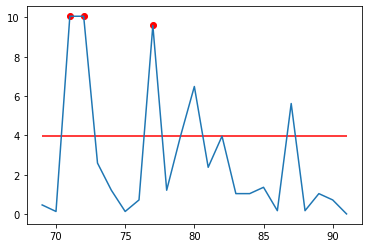

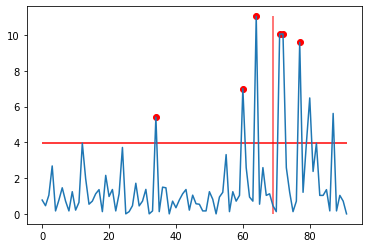

In [12]:

result_df = pd.DataFrame(
                            columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                            index=range(n_experiment))
random_s = random.sample(list(X.columns), len(X.columns) if len(X.columns) < 7 else 7)
X = X[random_s]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

result_scaler, result_inv_C, select_columns = fit_MTS(X_train, y_train)

y_train_pred = predict_MD(X_train, result_scaler, result_inv_C, select_columns)

threshold = determine_threshold(y_train, y_train_pred)

y_proba = predict_MD(X_test, result_scaler, result_inv_C, select_columns)
y_pred = y_proba > threshold

result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
display(result_df.iloc[0])
sns.lineplot(x=X_test.index, y=y_proba)
plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
plt.hlines(y=threshold, xmin=X_test.index.min(), xmax=X_test.index.max(), color='r')
plt.show()
sns.lineplot(x=X.index, y=predict_MD(X, result_scaler, result_inv_C, select_columns))
plt.scatter(x=y[y == 1].index, y=predict_MD(X, result_scaler, result_inv_C, select_columns)[y == 1], c='r')
plt.hlines(y=threshold, xmin=X.index.min(), xmax=X.index.max(), color='r')
# plt.vlines(x=X_test.index[0], ymin=0, ymax=predict_MD(X, result_scaler, result_inv_C, select_columns).max(), color='red', alpha=0.7)
plt.show()


In [9]:
predict_MD(X, result_scaler, result_inv_C, select_columns).max()

11.055929877085966

## MTSBag

AUC            0.966667
accuracy       0.913043
recall              0.9
Specificity         1.0
precision           1.0
gmeans         0.948683
RS                  0.9
Name: 0, dtype: object

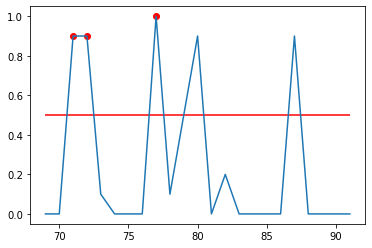

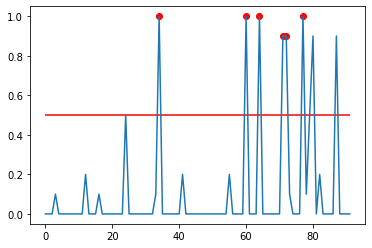

In [278]:

result_df = pd.DataFrame(
                    columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                    index=range(n_experiment))

# パラメータ
n_estimators = 10
max_samples = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# 実行するところ

# n_estimators:再標本化の回数 SIZE:再標本化されたもののサンプルサイズ
SIZE = int(len(X) * max_samples)

# 予測に必要なパラメータ
select_columns = [0] * n_estimators
result_scaler = [0] * n_estimators
result_inv_C = [0] * n_estimators
threshold = [0] * n_estimators

for i in range(n_estimators):
    # bootstrap sampling
    resampled_data_x, resampled_data_y = resample(X_train, y_train, n_samples = SIZE)
    random_s = random.sample(
        list(resampled_data_x.columns), 
        len(resampled_data_x.columns) 
        if len(resampled_data_x.columns) < 7 
        else 7
        )
    resampled_data_x = resampled_data_x[random_s]

    result_scaler[i], result_inv_C[i], select_columns[i] = fit_MTS(resampled_data_x, resampled_data_y)

    y_train_pred = predict_MD(resampled_data_x, result_scaler[i], result_inv_C[i], select_columns[i])

    threshold[i] = determine_threshold(resampled_data_y, y_train_pred)
    
y_proba, y_pred = predict_MTSBag(X_test, result_scaler, result_inv_C, select_columns, threshold, n_estimators)

result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
display(result_df.iloc[0])
sns.lineplot(x=X_test.index, y=y_proba)
plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
plt.hlines(y=0.5, xmin=X_test.index.min(), xmax=X_test.index.max(), color='r')
plt.show()
all_pred, _ = predict_MTSBag(X, result_scaler, result_inv_C, select_columns, threshold, n_estimators)

sns.lineplot(x=X.index, y=all_pred)
plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
plt.hlines(y=0.5, xmin=X.index.min(), xmax=X.index.max(), color='red')
plt.show()

In [226]:
threshold

[3.5031565722206555,
 3.5367389083969716,
 3.3916651416289745,
 2.649769736488925,
 3.211169138176566,
 3.4211817696561795,
 4.6669879704639925,
 2.941022557672549,
 4.046375228075873,
 5.2869325657179616]

MTSBagの欠点！！！
多数決だから極端な値になってしまう！！！
異常度を表せていない！！！！！

## MTSBagImpAgg

AUC                 1.0
accuracy       0.913043
recall              0.9
Specificity         1.0
precision           1.0
gmeans         0.948683
RS                  0.9
Name: 0, dtype: object

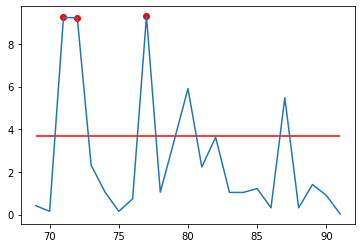

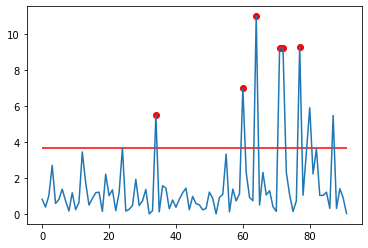

In [279]:
result_df = pd.DataFrame(
                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                index=range(n_experiment))
# パラメータ
n_estimators = 10
max_samples = 0.9

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# 実行するところ

# n_estimators:再標本化の回数 SIZE:再標本化されたもののサンプルサイズ
SIZE = int(len(X) * max_samples)

# 予測に必要なパラメータ
select_columns = [0] * n_estimators
result_scaler = [0] * n_estimators
result_inv_C = [0] * n_estimators
threshold = [0] * n_estimators

for i in range(n_estimators):
    # bootstrap sampling
    resampled_data_x, resampled_data_y = resample(X_train, y_train, n_samples = SIZE)
    random_s = random.sample(
        list(resampled_data_x.columns), 
        len(resampled_data_x.columns) 
        if len(resampled_data_x.columns) < 7 
        else 7
        )
    resampled_data_x = resampled_data_x[random_s]

    result_scaler[i], result_inv_C[i], select_columns[i] = fit_MTS(resampled_data_x, resampled_data_y)

    y_train_pred = predict_MD(resampled_data_x, result_scaler[i], result_inv_C[i], select_columns[i])

    threshold[i] = determine_threshold(resampled_data_y, y_train_pred)
    
y_proba, y_pred = predict_MTSBag_ImpAgg(X_test, result_scaler, result_inv_C, select_columns, threshold, n_estimators)

result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
display(result_df.iloc[0])
train_proba, _ = predict_MTSBag_ImpAgg(X_train, result_scaler, result_inv_C, select_columns, threshold, n_estimators)
all_threshold = determine_threshold(y_train, train_proba)

sns.lineplot(x=X_test.index, y=y_proba)
plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
plt.hlines(y=all_threshold, xmin=X_test.index.min(), xmax=X_test.index.max(), color='r')
plt.show()
all_pred, _ = predict_MTSBag_ImpAgg(X, result_scaler, result_inv_C, select_columns, threshold, n_estimators)

sns.lineplot(x=X.index, y=all_pred)
plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
plt.hlines(y=all_threshold, xmin=X.index.min(), xmax=X.index.max(), color='red')
plt.show()

## MTSBagSMOTE
- 余りにもデータが少ないとSMOTEを実行できない

In [223]:
from imblearn.over_sampling import SMOTE


result_df = pd.DataFrame(
                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                index=range(n_experiment))

# パラメータ
n_estimators = 10
max_samples = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# 実行するところ

# n_estimators:再標本化の回数 SIZE:再標本化されたもののサンプルサイズ
SIZE = int(len(X) * max_samples)

# 予測に必要なパラメータ
select_columns = [0] * n_estimators
result_scaler = [0] * n_estimators
result_inv_C = [0] * n_estimators
threshold = [0] * n_estimators

# SMOTEを実行
sampler = SMOTE()
SMOTE_X, SMOTE_y = sampler.fit_resample(X=X_train, y=y_train)
for i in range(n_estimators):
    # bootstrap sampling
    resampled_data_x, resampled_data_y = resample(SMOTE_X, SMOTE_y, n_samples = SIZE)
    random_s = random.sample(
        list(resampled_data_x.columns), 
        len(resampled_data_x.columns) 
        if len(resampled_data_x.columns) < 7 
        else 7
        )
    resampled_data_x = resampled_data_x[random_s]

    result_scaler[i], result_inv_C[i], select_columns[i] = fit_MTS(resampled_data_x, resampled_data_y)

    y_train_pred = predict_MD(resampled_data_x, result_scaler[i], result_inv_C[i], select_columns[i])
    
    threshold[i] = determine_threshold(resampled_data_y, y_train_pred)

y_proba, y_pred = predict_MTSBag(X_test, result_scaler, result_inv_C, select_columns, threshold, n_estimators)

result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
display(result_df.iloc[0])
sns.lineplot(x=X_test.index, y=y_proba)
plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
plt.show()
all_pred, _ = predict_MTSBag_ImpAgg(X, result_scaler, result_inv_C, select_columns, threshold, n_estimators)

sns.lineplot(x=X.index, y=all_pred)
plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
plt.show()

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6

## WMTGS

AUC                 1.0
accuracy       0.857143
recall         0.833333
Specificity         1.0
precision           1.0
gmeans         0.912871
RS             0.833333
Name: 0, dtype: object

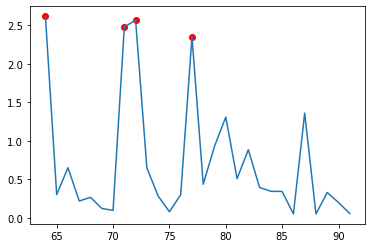

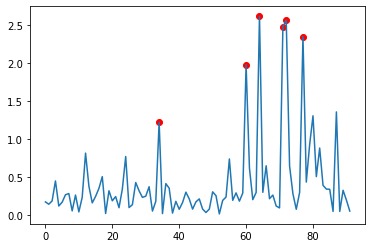

In [43]:

result_df = pd.DataFrame(
                            columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                            index=range(n_experiment))
random_s = random.sample(list(X.columns), len(X.columns) if len(X.columns) < 7 else 7)
X = X[random_s]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight = fit_WMTGS(X_train, y_train)
y_train_pred = cal_gram_WMD_by_reduced_model(X_train, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight)

threshold = determine_threshold(y_train, y_train_pred)

y_proba, y_pred = predict_WMTGS(X_test, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight, threshold)


result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
display(result_df.iloc[0])
sns.lineplot(x=X_test.index, y=y_proba)
plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
plt.show()
all_pred, _ = predict_WMTGS(X, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight, threshold)

sns.lineplot(x=X.index, y=all_pred)
plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
plt.show()
